In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder, CIFAR10
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Files already downloaded and verified
Files already downloaded and verified


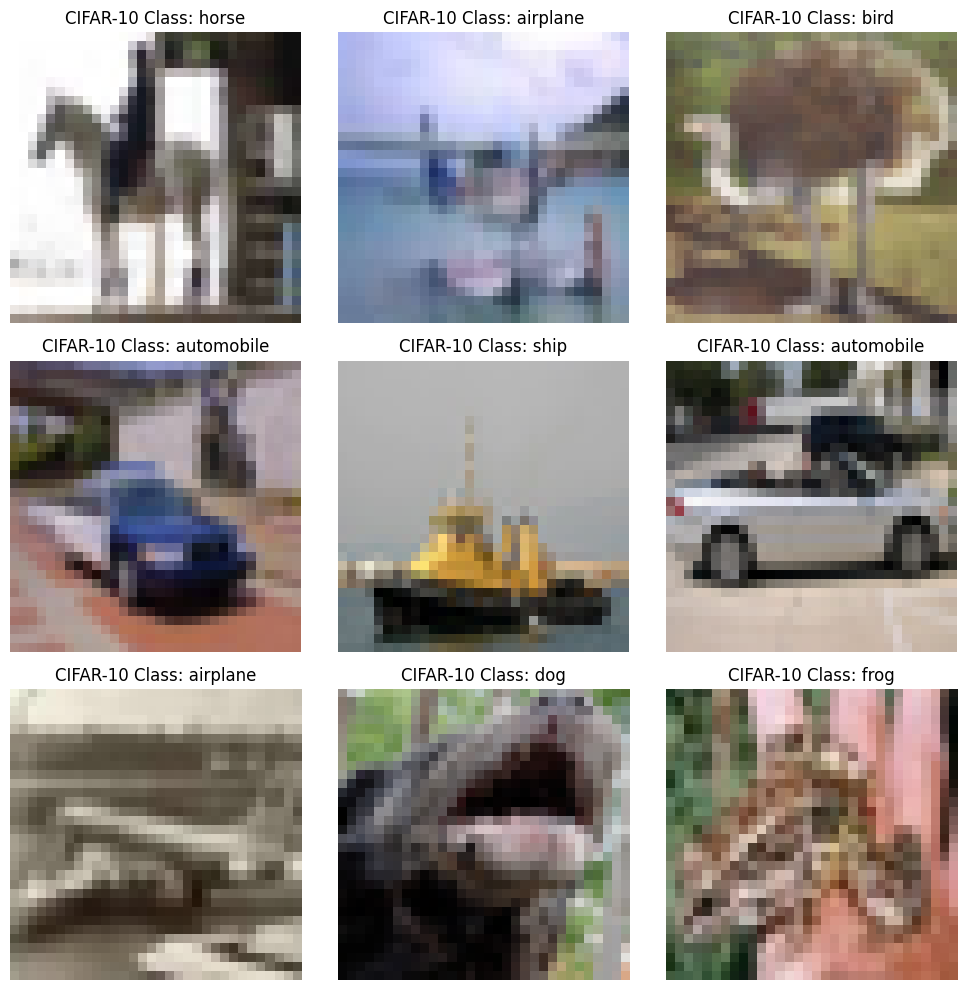

In [ ]:
# Define transforms for the images (you can add more augmentation as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset using torchvision
cifar10_train = CIFAR10(root='.', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='.', train=False, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

# Create data loaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)  # No need to shuffle test set

# Function to show random images
def show_random_images(dataset, class_names, ncols=3):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    random_indices = random.sample(range(len(dataset)), 9)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # (C, H, W) to (H, W, C)
        ax = axes.flat[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'CIFAR-10 Class: {class_names[label]}')

    plt.tight_layout()
    plt.show()

# Display random images with labels
show_random_images(train_dataset, cifar10_train.classes)


In [ ]:
len(train_dataset)

40000

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) #we have 3 in channels since we have 3 color rgb.
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # new convolutional layer

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=F.relu(self.conv3(x))
        x=torch.flatten(x,1) #We flatten our data along the color channels. So, first we had [batch_size, channels, height, width] and now we will have [batch_size, channels * height * width].
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        return x



In [ ]:
num_classes = len(cifar10_train.classes) # Number of classes is based on the dataset
model = CNN(num_classes)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001) #We will use the Adam optimizer in this case.
print(model)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
def train_model(model, optimizer, loss_fn, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0

        # Training phase
        model.train()  # Set the model to training mode
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # Print every 100 mini-batches
                print(f'Training: Epoch [{epoch + 1}, {i + 1}], Loss: {running_loss / 10:.3f}')
                running_loss = 0.0

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, loss_fn, test_loader)
        print(f'End of Epoch {epoch + 1}. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print('Finished Training')

# Assuming evaluate_model function is defined as per previous discussions
def evaluate_model(model, loss_fn, data_loader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy


In [ ]:
train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10)

Training: Epoch [1, 1000/40000 (2.50%)] Loss: 2.292
Training: Epoch [1, 2000/40000 (5.00%)] Loss: 2.236
Training: Epoch [1, 3000/40000 (7.50%)] Loss: 2.189
Training: Epoch [1, 4000/40000 (10.00%)] Loss: 2.180
Training: Epoch [1, 5000/40000 (12.50%)] Loss: 2.152
Training: Epoch [1, 6000/40000 (15.00%)] Loss: 2.150
Training: Epoch [1, 7000/40000 (17.50%)] Loss: 2.114
Training: Epoch [1, 8000/40000 (20.00%)] Loss: 2.149
Training: Epoch [1, 9000/40000 (22.50%)] Loss: 2.139
Training: Epoch [1, 10000/40000 (25.00%)] Loss: 2.150
Training: Epoch [1, 11000/40000 (27.50%)] Loss: 2.099
Training: Epoch [1, 12000/40000 (30.00%)] Loss: 2.136
Training: Epoch [1, 13000/40000 (32.50%)] Loss: 2.105
Training: Epoch [1, 14000/40000 (35.00%)] Loss: 2.103
Training: Epoch [1, 15000/40000 (37.50%)] Loss: 2.127
Training: Epoch [1, 16000/40000 (40.00%)] Loss: 2.066
Training: Epoch [1, 17000/40000 (42.50%)] Loss: 2.080
Training: Epoch [1, 18000/40000 (45.00%)] Loss: 2.044
Training: Epoch [1, 19000/40000 (47.50%)

In [ ]:
# Final evaluation on test set
test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 2.0082, Test Accuracy: 0.1788


In [ ]:
def train_model(model, optimizer, loss_fn, train_loader, test_loader, epochs=10):
    total_train_images = len(train_loader.dataset)
    total_test_images = len(test_loader.dataset)

    for epoch in range(epochs):
        running_loss = 0.0
        total_processed = 0

        # Training phase
        model.train()  # Set the model to training mode
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            batch_size = inputs.size(0)  # Get the batch size

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            total_processed += batch_size
            if i % 10 == 9:    # Print every 10 mini-batches
                avg_loss = running_loss / 10
                print(f'Training: Epoch [{epoch + 1}, {total_processed}/{total_train_images} ({total_processed / total_train_images * 100:.2f}%)] Loss: {avg_loss:.3f}')
                running_loss = 0.0

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, loss_fn, test_loader)
        print(f'End of Epoch {epoch + 1}. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print('Finished Training')

# Assuming evaluate_model function is defined as per previous discussions
def evaluate_model(model, loss_fn, data_loader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy


Files already downloaded and verified
Files already downloaded and verified


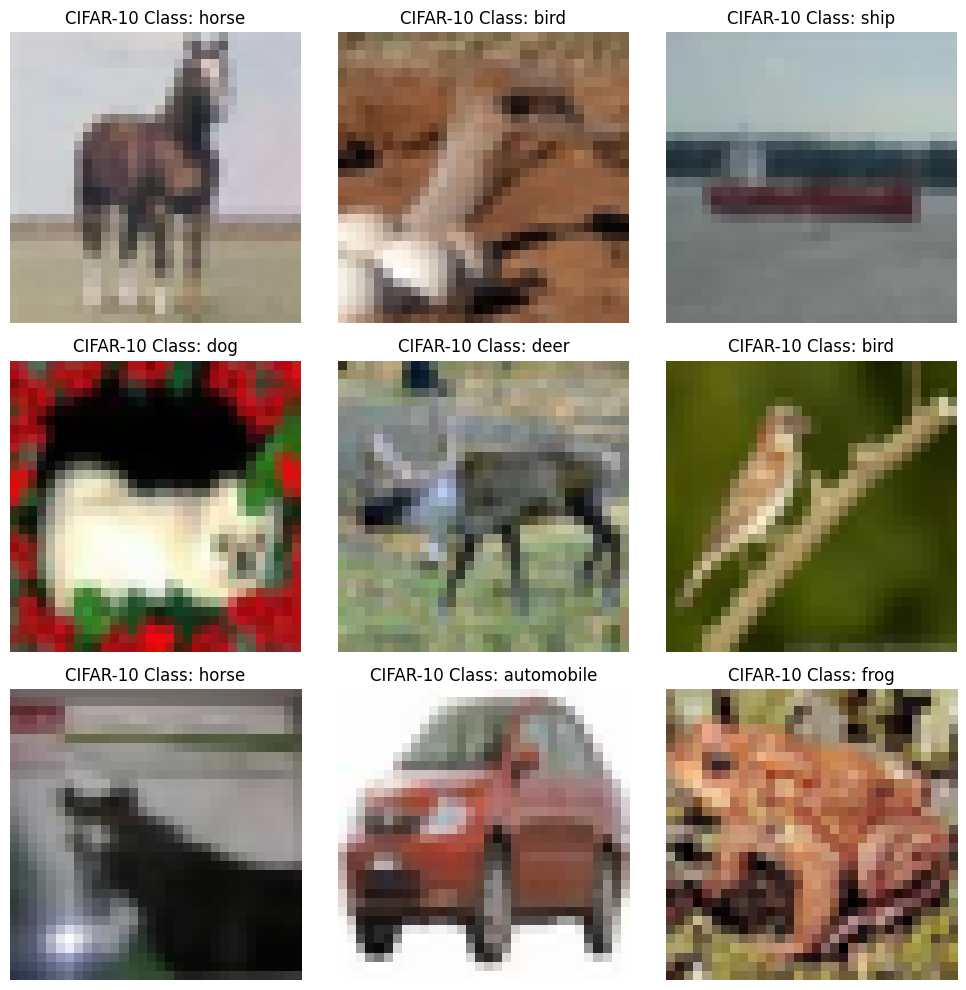

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training: Epoch [1, 9900/40000], Loss: 1.301
Training: Epoch [1, 19900/40000], Loss: 0.951
Training: Epoch [1, 29900/40000], Loss: 0.841
Training: Epoch [1, 39900/40000], Loss: 0.781
End of Epoch 1. Validation Loss: 0.8036, Validation Accuracy: 0.7292
Training: Epoch [2, 9900/40000], Loss: 0.647
Training: Epoch [2, 19900/40000], Loss: 0.663
Training: Epoch [2, 29900/40000], Loss: 0.623
Training: Epoch [2, 39900/40000], Loss: 0.622
End of Epoch 2. Validation Loss: 0.6813, Validation Accuracy: 0.7693
Training: Epoch [3, 9900/40000], Loss: 0.485
Training: Epoch [3, 19900/40000], Loss: 0.504
Training: Epoch [3, 29900/40000], Loss: 0.518
Training: Epoch [3, 39900/40000], Loss: 0.504
End of Epoch 3. Validation Loss: 0.6566, Validation Accuracy: 0.7783
Training: Epoch [4, 9900/40000], Loss: 0.347
Training: Epoch [4, 19900/40000], Loss: 0.396
Training: Epoch [4, 29900/40000], Loss: 0.415
Training: Epoch [4, 39900/40000], Loss: 0.411
End of Epoch 4. Validation Loss: 0.7670, Validation Accuracy:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
import random

# Define transforms for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset using torchvision
cifar10_train = CIFAR10(root='.', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='.', train=False, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

# Create data loaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

# Function to show random images
def show_random_images(dataset, class_names, ncols=3):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    random_indices = random.sample(range(len(dataset)), 9)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # (C, H, W) to (H, W, C)
        ax = axes.flat[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'CIFAR-10 Class: {class_names[label]}')

    plt.tight_layout()
    plt.show()

# Display random images with labels
show_random_images(train_dataset, cifar10_train.classes)

# Load a pretrained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0

        # Training phase
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Training: Epoch [{epoch + 1}, {i * batch_size}/{len(train_loader.dataset)}], Loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, loss_fn, val_loader)
        print(f'End of Epoch {epoch + 1}. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print('Finished Training')

# Function to evaluate the model
def evaluate_model(model, loss_fn, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Train the model
train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10)


In [ ]:
# Final evaluation on test set
test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.8199, Test Accuracy: 0.7876
